# Assignment 1 - Scott Wilkinson (V00887986) 

## Question 3: Finding Optimal p and k for KNN Regression

A notebook which uses a KNN regression model to predict the time of merger of simulated galaxies from IllustrisTNG based on their non-parametric morphology data.

First, we must import the necessary Python packages.

In [1]:
# importing packages used in notebook
import numpy as np
import matplotlib.pyplot as plt
import pymysql, os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor

In [2]:
# BTW if you need a package installed, you can use the following

#import os
#os.system('pip install pymysql')

## Importing Morphology Data

In [3]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
# select morphology params that have unflagged morphology fits
x = 'SELECT  dbID, asymmetry, shape_asymmetry, gini_m20_merger, concentration, outer_asymmetry, deviation, multimode, intensity \
    FROM simCFIS_morph\
    WHERE flag_morph = 0\
    AND asymmetry > -1'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats
morph = np.array(db_data, dtype = float).T[1:]

print(morph.shape)

(8, 219933)


# Merger Sample Selection

## Selecting a Sample of Pre-Merger Galaxies

Here is the reasoning behind my selection cuts:

1.  snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. rsep > 0 requires there to be two merging galaxies that are not on top of each other yet
3. mass ratio > 0.1, the merger will be significant when it occurs
4. Flaguntilmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code (see Hani et al. 2020, Rodriguez-Gomez et al. 2015)
5. Tuntilmerger < 0.5 ensures the merger will happen soon (< 500 Myr) and the galaxies have begun to gravitationally interact
6. Tpostmerger > 0.5 ensures no recent has occurred that would cause the disturbed morphology

In [4]:
#Query MySQL with reasoning described above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tuntilmerger, e.MassRatiountilmerger\
    FROM Environment e \
    WHERE snapNum>=50\
    AND rsep>0 \
    AND MassRatiountilmerger>=0.1\
    AND Flaguntilmerger = 1\
    AND Tuntilmerger < 0.5\
    AND Tpostmerger > 0.5'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_pre = np.array(db_data, dtype = str).T[0]
Mstar_pre = np.array(db_data, dtype = float).T[1]
Tum_pre = np.array(db_data, dtype = float).T[2]
mu_pre = np.array(db_data, dtype = float).T[3]

# give time before merger a negative value
Tum_pre *= -1

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tum_pre[Tum_pre == 0] = -0.05

# add 0 to match formatting with morphology catalogue
names_db_pre = np.array(['0'+n for n in names_db_pre])

print('There are {} pre-merger galaxies.'.format(len(names_db_pre)))

# match the two catalogues
match, idx_morph_pre, idx_pre = np.intersect1d(names_morph, names_db_pre, return_indices = True)

print('There are {} pre-merger galaxies with flag-free morphology data.'.format(len(names_db_pre[idx_pre])))

There are 7322 pre-merger galaxies.
There are 2886 pre-merger galaxies with flag-free morphology data.


## Selecting a Sample of Post-Merger Galaxies

Here is the reasoning behind my selection cuts:

1. snap >= 50 requires z<1 in the simulation (ie. enough time for galaxies to form, evolve and begin to merge)
2. mass ratio > 0.1, the merger that occurred was significant
3. Flagpostmerger = 1 ensures the merger is true and not a projection effect that confuses the `subfind` code
4. Tpostmerger < 0.5 requires a merger to have occurred in the last 500 Myr
5. rsep > 25 and Tuntilmerger < 0.5 requires there to be no nearby galaxies about to cause another merger in the next 500 Myr

In [5]:
#Query MySQL with the reasoning listed above
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'IllustrisTNG100_1', user = 'swilkinson', passwd = '123Sdss!@#')
x ='SELECT e.DB_ID, e.Mstar, e.Tpostmerger, e.MassRatio\
    FROM Environment e \
    WHERE snapNum>=50\
    AND MassRatio>=0.1\
    AND Flagpostmerger = 1\
    AND Tpostmerger < 0.5\
    AND rsep>25\
    AND Tuntilmerger > 0.5'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

names_db_post = np.array(db_data, dtype = str).T[0]
Mstar_post = np.array(db_data, dtype = float).T[1]
Tpm_post = np.array(db_data, dtype = float).T[2]
mu_post = np.array(db_data, dtype = float).T[3]

# add 0 to match formatting with morphology catalogue
names_db_post = np.array(['0'+n for n in names_db_post])

# differentiate pre-merger galaxies that merge within the next snapshot from post-merger galaxies
#   that have merged within the last snap shot by adding / subtracting 0.1Gyr (approx the middle of a snapshot)
Tpm_post[Tpm_post == 0] = 0.05

print('There are {} post-merger galaxies.'.format(len(names_db_post)))

# match with morphology catalogue
match, idx_morph_post, idx_post = np.intersect1d(names_morph, names_db_post, return_indices = True)

print('There are {} post-merger galaxies with flag-free morphology data.'.format(len(names_db_post[idx_post])))

names_db_post = names_db_post[idx_post]
Mstar_post = Mstar_post[idx_post]
Tpm_post = Tpm_post[idx_post]
mu_post = mu_post[idx_post]

There are 5153 post-merger galaxies.
There are 3456 post-merger galaxies with flag-free morphology data.


# Preparing Data for Model

In [6]:
# list of all merging galaxies
names_mergers = np.array(list(names_db_pre) + list(names_db_post))
T_merger = np.array(list(Tum_pre) + list(Tpm_post))
mu = np.array(list(mu_pre) + list(mu_post))
mass = np.array(list(Mstar_pre) + list(Mstar_post))

# match catalogues
match, idx_morph, idx_merge = np.intersect1d(names_morph, names_mergers, return_indices = True)

T_merger = T_merger[idx_merge]
mu = mu[idx_merge]
mass = mass[idx_merge]
morph = morph[:,idx_morph]

In [7]:
# shape of output
print(morph.shape)

(8, 6342)


In [8]:
# shape of output
print(T_merger.shape)

(6342,)


In [9]:
# create training and validation sets (75/25 split)

input_tr,input_va,target_tr, target_va = train_test_split(morph.T, T_merger,test_size=0.25, shuffle = True)
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, mu, test_size=0.25, shuffle = True)
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, mass,test_size=0.25, shuffle = True)

In [10]:
### normalizing inputs

# fit on training set
scaler = StandardScaler().fit(input_tr)  

# normalize training
input_tr_norm= scaler.transform(input_tr) 

# normalize validation with same scaler & fit
input_va_norm= scaler.transform(input_va)

# K-Nearest Neighbours Regression

Rather than choosing values of p and k by hand, in this section, I create a function that completes a KNN regression task for my data and takes values of p and k as input. I will loop through reasonable values of k for both p=1 and p=2 and attempt to find the optimal p and k. I will define optimal p and k as that which minimizes $\sigma$, the standard deviation of the difference between predicted and true values of the target, and $\mu$, the mean of the absolute difference between the predicted and true values of the target, ie. minimizing how far off the predictions are from truth and the scatter of those predictions (ideally, you don't want good performance for some and very bad for others, increasing $\sigma$).

In [11]:
def run_KNN(p,k):
    
    '''
    A function that fits a KNN regressor with number of neighbours k and power parameter of the minkowski metric p.
    '''
    
    # define hyper parameters
    KNN = KNeighborsRegressor(n_neighbors=k, p=p)
    
    # fit the model with training set
    KNN.fit(input_tr_norm,target_tr)  
    
    #'predictions for training and validation sets'
    target_tr_pred= KNN.predict(input_tr_norm)  
    target_va_pred= KNN.predict(input_va_norm)
    
    mu = np.mean(np.abs(target_tr-target_tr_pred))
    median = np.median(target_tr-target_tr_pred)
    sigma = np.std(target_tr-target_tr_pred)

    muv = np.mean(np.abs(target_va-target_va_pred))
    medianv = np.median(target_va-target_va_pred)
    sigmav = np.std(target_va-target_va_pred)
    
    return mu, sigma, muv, sigmav

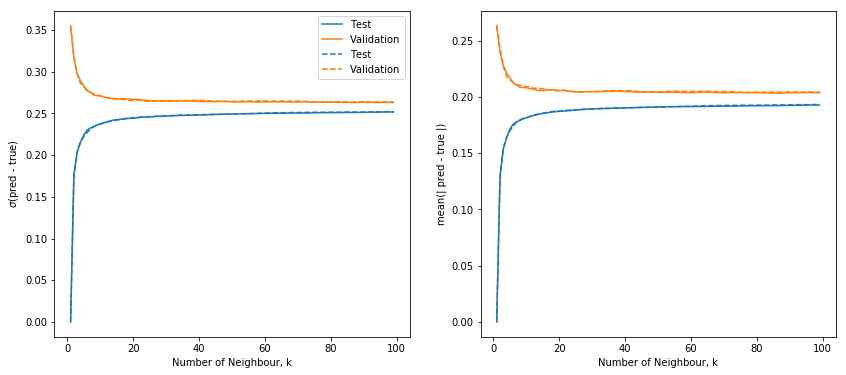

In [12]:
# range of p and k to consider
K = np.arange(1,100)
P = [1,2]

fig, [ax1,ax2] = plt.subplots(1,2, figsize = (14,6))

for p in P:
    
    mu, sigma, muv, sigmav = [],[],[],[]
    
    for k in K:
    
        # fit KNN with p and k
        mu_tmp, sigma_tmp, muv_tmp, sigmav_tmp = run_KNN(p,k)
    
        # append to list
        mu.append(mu_tmp)
        sigma.append(sigma_tmp)
        muv.append(muv_tmp)
        sigmav.append(sigmav_tmp)
    
    if p == 2:
        ls = '--'
    else: 
        ls = '-'
    
    # plot metrics as a function of k
    ax1.plot(K, sigma, color = 'tab:blue', label = 'Test', ls = ls)
    ax1.plot(K, sigmav, color = 'tab:orange', label = 'Validation', ls = ls)
    ax1.set_xlabel('Number of Neighbour, k')
    ax1.set_ylabel('$\sigma$(pred - true)')
    ax1.legend(fancybox = True)
    
    ax2.plot(K, mu, color = 'tab:blue', label = 'Test', ls = ls)
    ax2.plot(K, muv, color = 'tab:orange', label = 'Validation', ls = ls)
    ax2.set_xlabel('Number of Neighbour, k')
    ax2.set_ylabel('mean(| pred - true |)')

plt.show()

By looping through p and k and plotting the diagnostic metrics $\sigma$ (left) and $\mu$ (right), we do not see a clear minimization of either metric at any given k. Furthermore, the performance with p=1 or p=2 is almost identical with p=2 producing slightly slower $\sigma$ and $\mu$ in the validation set. 

Since there is no clear minimization, I chose k = 25 and p=2 as my optimal p and k. Beyond this $\sigma$ and $\mu$ are relatively stable.

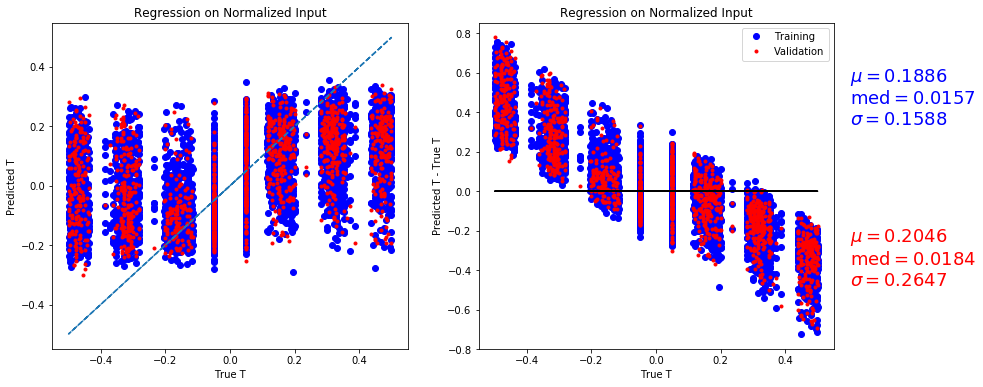

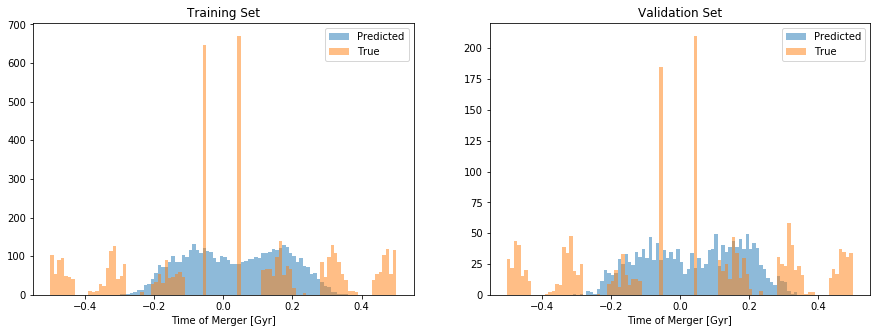

In [13]:
# define hyper parameters
KNN = KNeighborsRegressor(n_neighbors=25, p=2)

# fit the model with training set
KNN.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr_norm)  
target_va_pred= KNN.predict(input_va_norm)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True T')
ax1.set_ylabel('Predicted T')
ax1.set_title('Regression on Normalized Input')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True T')
ax2.set_ylabel('Predicted T - True T')
ax2.set_title('Regression on Normalized Input')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(np.abs(target_tr-target_tr_pred))

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Time of Merger [Gyr]')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [-0.5,0.5], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Time of Merger [Gyr]')
ax2.legend(fancybox = True)

plt.show()

Even at optimal p and k, the model does not perform well on this data set. Let's try again on a different data set.

# As previously discussed, this model has difficulty fitting this data set. Try on real galaxies instead and use a different target.

In [14]:
#Query SQL for morphology data
# connects to database
db = pymysql.connect(host = 'lauca.phys.uvic.ca', db = 'sdss', user = 'swilkinson', passwd = '123Sdss!@#')
x = 'SELECT  s.objID, asymmetry, shape_asymmetry, gini, m20, concentration, total_mass_med\
    FROM dr7_cfis_statmorph_newmask s, dr7_uberuber u\
    WHERE u.objID = s.objID\
    AND flag_morph = 0\
    AND asymmetry > -1\
    AND total_sfr_med>-5\
    AND total_mass_med > 7'
c = db.cursor()
c.execute(x)
db_data = c.fetchall()
c.close()
db.close()

# save names as a string
names_morph = np.array(db_data, dtype = str).T[0]

# save rest of data as floats
morph = np.array(db_data, dtype = float).T[1:-1]

sfr = np.array(db_data, dtype = float).T[-1:]

print(morph.shape)
print(sfr.shape)

(5, 147063)
(1, 147063)


In [15]:
#input_tr,input_va,target_tr, target_va = train_test_split(morph.T, sfr.T,test_size=0.25, shuffle = True)
input_tr,input_va,target_tr, target_va = train_test_split(morph[:-1].T, morph[-1].T,test_size=0.25, shuffle = True)

### normalizing inputs

# fit on training set
scaler = StandardScaler().fit(input_tr)  

# normalize training
input_tr_norm= scaler.transform(input_tr)

# normalize validation with same scaler & fit
input_va_norm= scaler.transform(input_va)

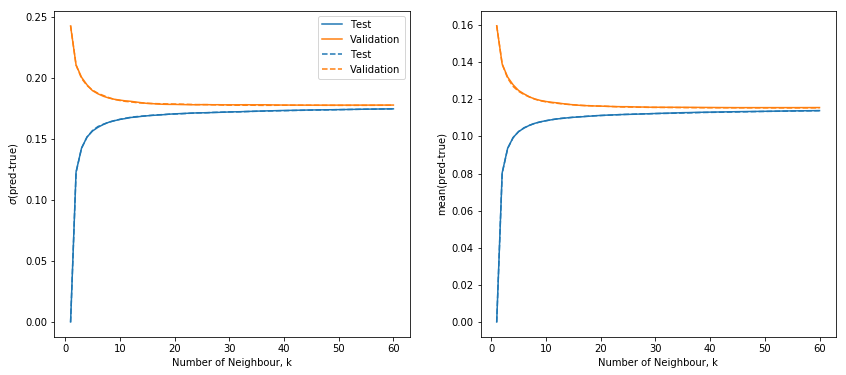

In [17]:

K = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,\
    21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,\
    39,40,45,50,55,60]
P = [1,2]

fig, [ax1,ax2] = plt.subplots(1,2, figsize = (14,6))

for p in P:
    
    mu, sigma, muv, sigmav = [],[],[],[]
    
    for k in K:
    
        mu_tmp, sigma_tmp, muv_tmp, sigmav_tmp = run_KNN(p,k)
    
        mu.append(mu_tmp)
        sigma.append(sigma_tmp)
        muv.append(muv_tmp)
        sigmav.append(sigmav_tmp)
    
    if p == 2:
        ls = '--'
    else: 
        ls = '-'
    
    ax1.plot(K, sigma, color = 'tab:blue', label = 'Test', ls = ls)
    ax1.plot(K, sigmav, color = 'tab:orange', label = 'Validation', ls = ls)
    ax1.set_xlabel('Number of Neighbour, k')
    ax1.set_ylabel('$\sigma$(pred-true)')
    ax1.legend(fancybox = True)
    
    ax2.plot(K, mu, color = 'tab:blue', label = 'Test', ls = ls)
    ax2.plot(K, muv, color = 'tab:orange', label = 'Validation', ls = ls)
    ax2.set_xlabel('Number of Neighbour, k')
    ax2.set_ylabel('mean(pred-true)')

plt.show()

[55]


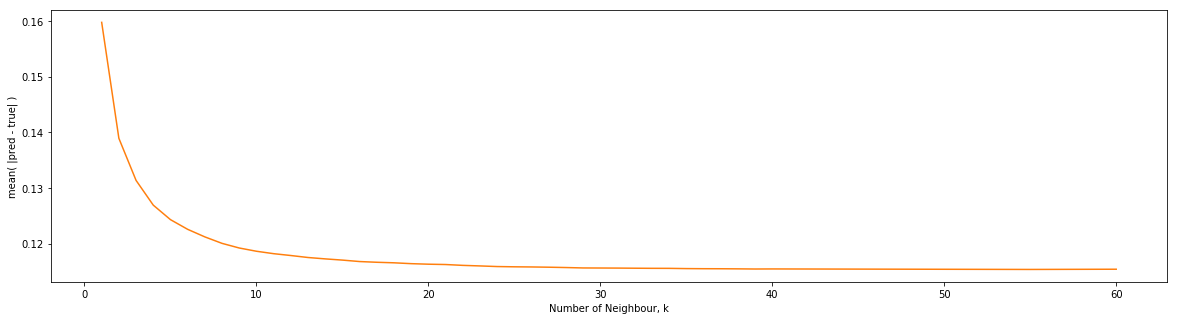

In [20]:
fig, ax = plt.subplots(1,1, figsize = (20,5))


#ax.plot(K, mu, color = 'tab:blue', label = 'Test', ls = 'o-')
ax.plot(K, muv, color = 'tab:orange', label = 'Validation')
ax.set_xlabel('Number of Neighbour, k')
ax.set_ylabel('mean( |pred - true| )')

plt.show()

No clear minimum so I will use k = 25 again. Increasing k causes computation time to be unreasonable.

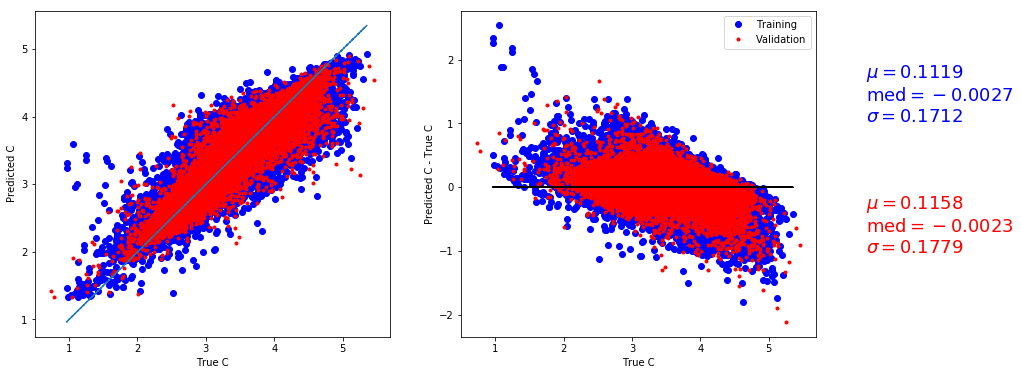

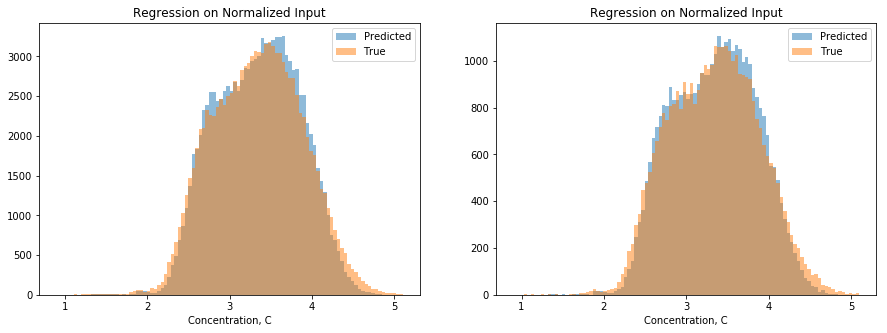

In [21]:
# define hyper parameters
KNN = KNeighborsRegressor(n_neighbors=25, p=2)

# fit the model with training set
KNN.fit(input_tr_norm,target_tr)  

#'predictions for training and validation sets'
target_tr_pred= KNN.predict(input_tr_norm)  
target_va_pred= KNN.predict(input_va_norm)

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (14,6))

ax1.plot(target_tr,target_tr_pred, 'ob')
ax1.plot(target_va,target_va_pred, '.r')
ax1.plot(target_tr, target_tr, '--')
ax1.set_xlabel('True C')
ax1.set_ylabel('Predicted C')

ax2.plot(target_tr,target_tr_pred-target_tr,'o', color = 'blue')
ax2.plot(target_va,target_va_pred-target_va,'.', color = 'red')
ax2.plot(target_tr,np.zeros(len(target_tr)), '-k')
ax2.set_xlabel('True C')
ax2.set_ylabel('Predicted C - True C')
ax2.legend(['Training', 'Validation'])

mu = np.mean(np.abs(target_tr-target_tr_pred))
median = np.median(target_tr-target_tr_pred)
sigma = np.std(target_tr-target_tr_pred)

muv = np.mean(np.abs(target_va-target_va_pred))
medianv = np.median(target_va-target_va_pred)
sigmav = np.std(target_va-target_va_pred)

textstr = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(mu, median, sigma)
textstrv = '$\mu=%.4f$\n$\mathrm{med}=%.4f$\n$\sigma=%.4f$'%(muv, medianv, sigmav)

ax2.text(1.2*max(target_tr),0.5*max(target_va-target_va_pred),textstr, color='b',fontsize=18)
ax2.text(1.2*max(target_tr),0.6*min(target_va-target_va_pred),textstrv, color='r',fontsize=18)

plt.show()

fig, [ax1, ax2] = plt.subplots(1,2,figsize = (15,5))

ax1.hist(target_tr_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax1.hist(target_tr, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax1.set_title('Training Set')
ax1.set_xlabel('Concentration, C')
ax1.set_title('Regression on Normalized Input')
ax1.legend(fancybox = True)

ax2.hist(target_va_pred, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'Predicted')
ax2.hist(target_va, bins = 100, range = [0.9,5.1], alpha = 0.5, label = 'True')
ax2.set_title('Validation Set')
ax2.set_xlabel('Concentration, C')
ax2.set_title('Regression on Normalized Input')
ax2.legend(fancybox = True)

plt.show()

It seems that no minumum is reached for k-neighbours up to 60. Beyond this computation time hinders my ability to probe any further but from some testing, it seems to go back up and the minimum is approximately in the range I have chosen. 

I believe this is the case because of the size of my data set (150,000!). With such a large size, even 60 neighbours is not that much. 